In [1]:
import numpy as np
import pandas as pd
import vectorbt as vbt

In [2]:
split_kwargs = dict(
    n=30, 
    window_len=365 * 2, 
    set_lens=(180,), 
    left_to_right=False
)  # 30 windows, each 2 years long, reserve 180 days for test
pf_kwargs = dict(
    direction='both',  # long and short
    freq='d'
)
windows = np.arange(10, 50)

In [3]:
price = vbt.YFData.download('BTC-USD').get('Close')

In [4]:
print(price)

Date
2014-09-17 00:00:00+00:00      457.334015
2014-09-18 00:00:00+00:00      424.440002
2014-09-19 00:00:00+00:00      394.795990
2014-09-20 00:00:00+00:00      408.903992
2014-09-21 00:00:00+00:00      398.821014
                                 ...     
2021-08-21 00:00:00+00:00    48905.492188
2021-08-22 00:00:00+00:00    49321.652344
2021-08-23 00:00:00+00:00    49546.148438
2021-08-24 00:00:00+00:00    47706.117188
2021-08-25 00:00:00+00:00    47449.765625
Name: Close, Length: 2531, dtype: float64


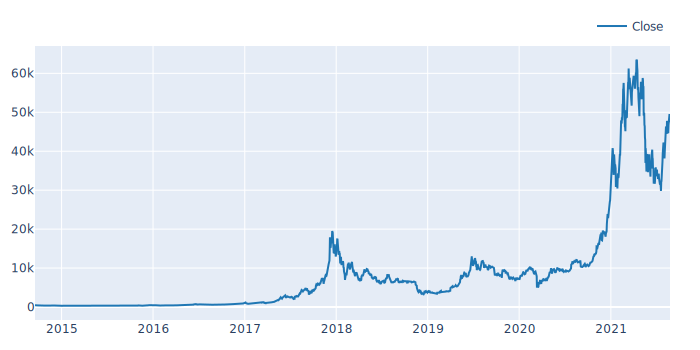

In [5]:
price.vbt.plot().show_svg()

In [6]:
def roll_in_and_out_samples(price, **kwargs):
    return price.vbt.rolling_split(**kwargs)

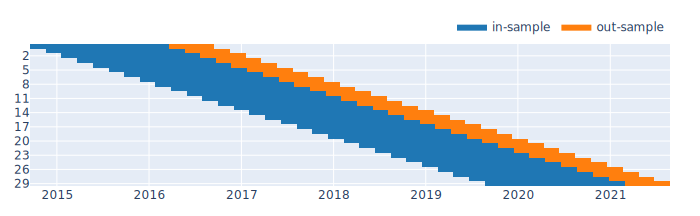

In [7]:
roll_in_and_out_samples(price, **split_kwargs, plot=True, trace_names=['in-sample', 'out-sample']).show_svg()

In [8]:
(in_price, in_indexes), (out_price, out_indexes) = roll_in_and_out_samples(price, **split_kwargs)

print(in_price.shape, len(in_indexes))  # in-sample
print(out_price.shape, len(out_indexes))  # out-sample

(550, 30) 30
(180, 30) 30


In [9]:
def simulate_holding(price, **kwargs):
    pf = vbt.Portfolio.from_holding(price, **kwargs)
    return pf.sharpe_ratio()

In [10]:
in_hold_sharpe = simulate_holding(in_price, **pf_kwargs)

print(in_hold_sharpe)

split_idx
0     0.229171
1     0.493885
2     1.576114
3     1.255349
4     1.697116
5     1.606954
6     2.000155
7     2.398767
8     2.377776
9     2.539653
10    3.037085
11    2.605911
12    2.259943
13    2.064727
14    1.840279
15    1.695307
16    0.631063
17    0.493426
18    0.466068
19   -0.139716
20    0.576409
21    0.395839
22    0.402171
23    0.779667
24    0.484766
25    1.206379
26    1.356616
27    1.193132
28    1.207407
29    1.740877
Name: sharpe_ratio, dtype: float64


In [11]:
def simulate_all_params(price, windows, **kwargs):
    fast_ma, slow_ma = vbt.MA.run_combs(price, windows, r=2, short_names=['fast', 'slow'])
    entries = fast_ma.ma_crossed_above(slow_ma)
    exits = fast_ma.ma_crossed_below(slow_ma)
    pf = vbt.Portfolio.from_signals(price, entries, exits, **kwargs)
    return pf.sharpe_ratio()

In [12]:
# Simulate all params for in-sample ranges
in_sharpe = simulate_all_params(in_price, windows, **pf_kwargs)

print(in_sharpe)

fast_window  slow_window  split_idx
10           11           0            0.856870
                          1            1.125426
                          2            0.497444
                          3            0.366434
                          4            0.845251
                                         ...   
48           49           25          -0.072416
                          26          -0.403375
                          27          -1.093233
                          28          -0.921787
                          29          -0.593033
Name: sharpe_ratio, Length: 23400, dtype: float64


In [13]:
def get_best_index(performance, higher_better=True):
    if higher_better:
        return performance[performance.groupby('split_idx').idxmax()].index
    return performance[performance.groupby('split_idx').idxmin()].index

In [14]:
in_best_index = get_best_index(in_sharpe)

print(in_best_index)

MultiIndex([(27, 29,  0),
            (19, 27,  1),
            (21, 25,  2),
            (23, 25,  3),
            (23, 25,  4),
            (44, 45,  5),
            (30, 48,  6),
            (37, 43,  7),
            (10, 21,  8),
            (10, 21,  9),
            (10, 21, 10),
            (10, 21, 11),
            (10, 21, 12),
            (10, 21, 13),
            (10, 21, 14),
            (10, 22, 15),
            (10, 22, 16),
            (10, 22, 17),
            (17, 22, 18),
            (18, 19, 19),
            (13, 21, 20),
            (45, 49, 21),
            (45, 49, 22),
            (18, 21, 23),
            (13, 21, 24),
            (15, 18, 25),
            (13, 20, 26),
            (13, 20, 27),
            (13, 20, 28),
            (13, 20, 29)],
           names=['fast_window', 'slow_window', 'split_idx'])


In [15]:
def get_best_params(best_index, level_name):
    return best_index.get_level_values(level_name).to_numpy()

In [16]:
in_best_fast_windows = get_best_params(in_best_index, 'fast_window')
in_best_slow_windows = get_best_params(in_best_index, 'slow_window')
in_best_window_pairs = np.array(list(zip(in_best_fast_windows, in_best_slow_windows)))

print(in_best_window_pairs)

[[27 29]
 [19 27]
 [21 25]
 [23 25]
 [23 25]
 [44 45]
 [30 48]
 [37 43]
 [10 21]
 [10 21]
 [10 21]
 [10 21]
 [10 21]
 [10 21]
 [10 21]
 [10 22]
 [10 22]
 [10 22]
 [17 22]
 [18 19]
 [13 21]
 [45 49]
 [45 49]
 [18 21]
 [13 21]
 [15 18]
 [13 20]
 [13 20]
 [13 20]
 [13 20]]


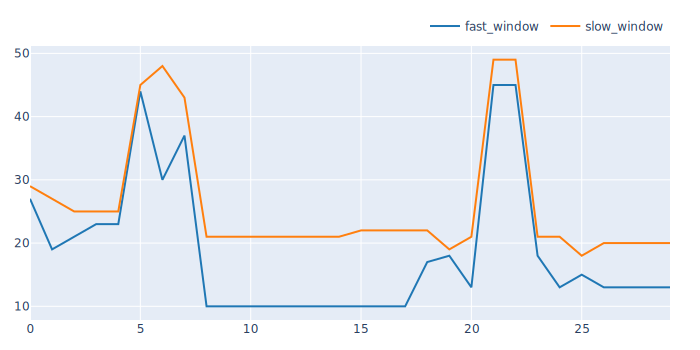

In [17]:
pd.DataFrame(in_best_window_pairs, columns=['fast_window', 'slow_window']).vbt.plot().show_svg()

In [18]:
out_hold_sharpe = simulate_holding(out_price, **pf_kwargs)

print(out_hold_sharpe)

split_idx
0     1.773721
1     2.255167
2     1.605040
3     2.302425
4     3.470567
5     3.208988
6     3.335303
7     3.245646
8     3.099480
9     1.633831
10   -0.118486
11    0.140842
12    0.192643
13   -1.635978
14   -1.918136
15   -0.525469
16    2.720792
17    3.453221
18    1.631937
19    0.085609
20    0.291843
21    0.060253
22    1.204436
23    0.876595
24    2.097729
25    3.843597
26    4.741930
27    3.892515
28    1.066166
29    0.470709
Name: sharpe_ratio, dtype: float64


In [19]:
# Simulate all params for out-sample ranges
out_sharpe = simulate_all_params(out_price, windows, **pf_kwargs)

print(out_sharpe)

fast_window  slow_window  split_idx
10           11           0           -1.018512
                          1           -0.279485
                          2           -0.097736
                          3            1.209532
                          4            2.518178
                                         ...   
48           49           25           0.938274
                          26           4.069947
                          27           3.016070
                          28           0.108060
                          29          -0.482026
Name: sharpe_ratio, Length: 23400, dtype: float64


In [20]:
def simulate_best_params(price, best_fast_windows, best_slow_windows, **kwargs):
    fast_ma = vbt.MA.run(price, window=best_fast_windows, per_column=True)
    slow_ma = vbt.MA.run(price, window=best_slow_windows, per_column=True)
    entries = fast_ma.ma_crossed_above(slow_ma)
    exits = fast_ma.ma_crossed_below(slow_ma)
    pf = vbt.Portfolio.from_signals(price, entries, exits, **kwargs)
    return pf.sharpe_ratio()

In [21]:
# Use best params from in-sample ranges and simulate them for out-sample ranges
out_test_sharpe = simulate_best_params(out_price, in_best_fast_windows, in_best_slow_windows, **pf_kwargs)

print(out_test_sharpe)

ma_window  ma_window  split_idx
27         29         0            1.164082
19         27         1            0.501229
21         25         2            1.414590
23         25         3            1.031654
                      4            1.431372
44         45         5            1.120318
30         48         6            0.425328
37         43         7           -0.564391
10         21         8            3.439371
                      9            2.783249
                      10           1.187116
                      11           1.771893
                      12           0.341544
                      13           0.065343
                      14           0.030836
           22         15           1.702848
                      16           2.727809
                      17           0.861896
17         22         18           0.476459
18         19         19           0.433287
13         21         20           1.762454
45         49         21          -2.053022


In [22]:
cv_results_df = pd.DataFrame({
    'in_sample_hold': in_hold_sharpe.values,
    'in_sample_median': in_sharpe.groupby('split_idx').median().values,
    'in_sample_best': in_sharpe[in_best_index].values,
    'out_sample_hold': out_hold_sharpe.values,
    'out_sample_median': out_sharpe.groupby('split_idx').median().values,
    'out_sample_test': out_test_sharpe.values
})

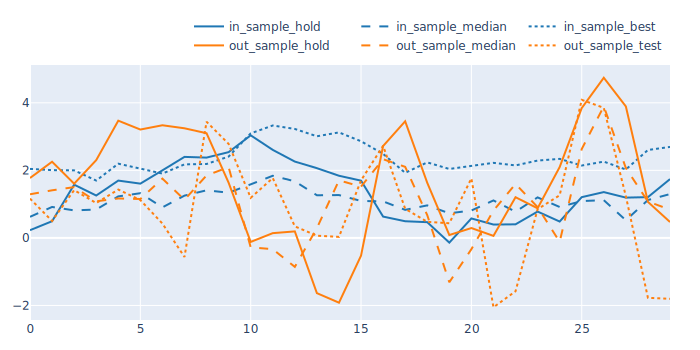

In [23]:
color_schema = vbt.settings['plotting']['color_schema']

cv_results_df.vbt.plot(
    trace_kwargs=[
        dict(line_color=color_schema['blue']),
        dict(line_color=color_schema['blue'], line_dash='dash'),
        dict(line_color=color_schema['blue'], line_dash='dot'),
        dict(line_color=color_schema['orange']),
        dict(line_color=color_schema['orange'], line_dash='dash'),
        dict(line_color=color_schema['orange'], line_dash='dot')
    ]
).show_svg()